### Problem 1: 
Assume zero initial environmental flow, therefore initial stream function is zero everywhere. At the top and bottom boundaries, y remains zero always, which is the top and bottom boundary conditions for y. or H and L = 10,000 m, and Dx = Dz = 100 m,
h =h cos2 æp r ö for r £ R otherwise h = 0, (8)
0 ç2R÷ èø
where r is the radial distance from the domain center, and R = 1⁄4 H.
For the above vorticity distribution and h0 = 0.01 s-1 solve for the stream function y using successive over-relaxation method. Confirm that your results are correct by plotting (within the
physical domain without extra boundary points) the original h and h calculated from (6). Calculate u and w from (5) and plot the wind vectors in the physical domain.

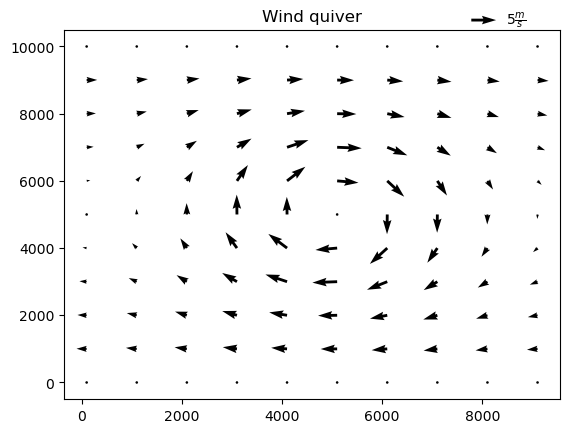

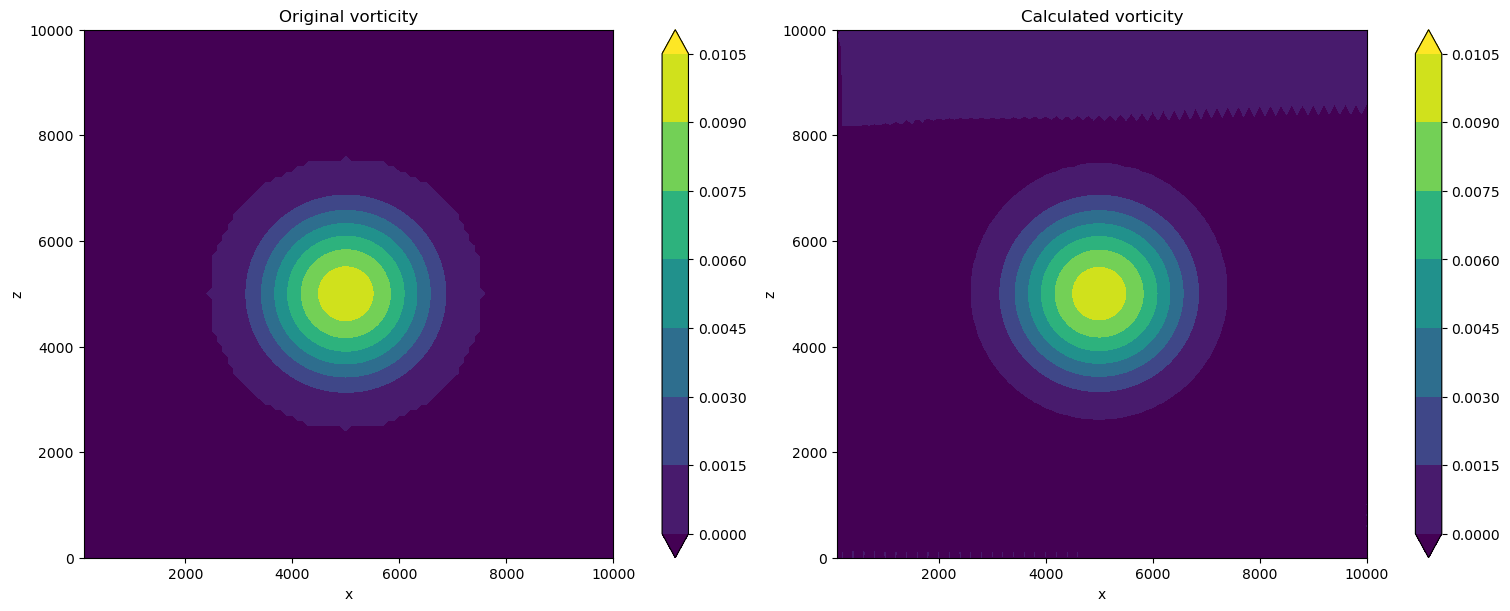

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
H = 10000  # Depth of the domain
L = 10000  # Width of the domain
dx = 100  # Grid spacing in x-direction
dz = 100  # Grid spacing in z-direction
#
# Using 2 extra column for lateral boundary conditions
nx = int(L / dx) + 3  # Number of grid points in x
nz = int(H / dz) + 1  # Number of grid points in z

# Create grid
x = np.linspace(0, L + dx * 2, nx)  # x direction grid, including extra boundary points
z = np.linspace(0, H, nz)  # y direction grid
X, Z = np.meshgrid(x, z)

# Initialize stream function and vorticity arrays
psi = np.zeros((nz, nx))  # stream function
eta = np.zeros((nz, nx))  # original vorticity
eta_c = np.zeros((nz, nx))  # calculated vorticity

# Boundary conditions for stream function
psi[0, :] = 0  # Bottom boundary
psi[-1, :] = 0  # Top boundary

# Initial vorticity distribution
eta0 = 0.01  # s^-1
R = H / 4
for i in range(1, nz - 1, 1):
    for j in range(1, nx - 1, 1):
        r = np.sqrt((X[i, j] - L / 2) ** 2 + (Z[i, j] - H / 2) ** 2)
        if r <= R:
            eta[i, j] = eta0 * np.cos(np.pi * r / (2 * R)) ** 2
        else:
            eta[i, j] = 0


# Function to apply boundary conditions for u
def apply_boundary_conditions(u):
    u[0, :] = u[-1, :] = 0  # Top boundary (rigid lid)
    u[:, 0] = u[:, nx - 2]  # Periodic boundary conditions
    u[:, nx - 1] = u[:, 1]  # Periodic boundary conditions
    return u


# Solve for stream function psi using SOR method
def solve_stream_function(dz, dx, nz, nx, eta, psi):
    # INPUT
    # dz, dx: grid spacing
    # nz, nx: grid number
    # eta: original vorticiy
    # psi: the first guess of stream function
    #
    # OUTPUT
    # psi: updated stream function
    #
    # Calculate coefficients for R
    cx = dz**2 / (2 * (dx**2 + dz**2))
    cz = dx**2 / (2 * (dx**2 + dz**2))
    C = (dx**2 * dz**2) / (2 * (dx**2 + dz**2))

    # Calculate alpha
    # Using the grid interval calculate t_m
    # For x direction only calculate in physical domain without extra boundary points.
    t_m = np.cos(np.pi / (nx - 3)) + np.cos(np.pi / (nz - 1))
    alpha = (8.0 - 4.0 * np.sqrt(4.0 - t_m**2.0)) / t_m**2.0

    for i in np.arange(1, nx - 1, 1):
        for k in np.arange(1, nz - 1, 1):
            R = (
                cx * (psi[k, i + 1] + psi[k, i - 1])
                + cz * (psi[k + 1, i] + psi[k - 1, i])
                - C * eta[k, i]
                - psi[k, i]
            )
            psi[k, i] = psi[k, i] + alpha * R
    # Call apply lateral boundary conditions
    apply_boundary_conditions(psi)

    return psi


# Main loop for call function and calculate the stream function
max_iterations = 200
for iteration in range(max_iterations):
    solve_stream_function(dz, dx, nz, nx, eta, psi)

# Central difference scheme
# Calculate the vorticity by del^psi=eta
for i in np.arange(1, nx - 1, 1):
    for k in np.arange(1, nz - 1, 1):
        eta_c[k, i] = (psi[k + 1, i] - 2 * psi[k, i] + psi[k - 1, i]) / dz**2 + (
            psi[k, i + 1] - 2 * psi[k, i] + psi[k, i - 1]
        ) / dx**2
# Call apply lateral boundary conditions
eta_c = apply_boundary_conditions(eta_c)

# Compute velocity components from stream function
u = np.zeros_like(psi)
w = np.zeros_like(psi)
u[1:-1, :] = (psi[2:, :] - psi[:-2, :]) / (2 * dz)
w[:, 1:-1] = -(psi[:, 2:] - psi[:, :-2]) / (2 * dx)
# Apply boundary conditions
u = apply_boundary_conditions(u)
w = apply_boundary_conditions(w)

# Plot the velocity vector as quiver map
plt.figure()
plt.title("Wind quiver")
# Plot the wind quiver every 10 points
# Only plot the physical domain without the extra boundary
q = plt.quiver(
    X[::10, 1:-2:10],
    Z[::10, 1:-2:10],
    u[::10, 1:-2:10],
    w[::10, 1:-2:10],
    scale=100,
    units="width",
)
qk = plt.quiverkey(
    q, 0.8, 0.9, 5, r"$5 \frac{m}{s}$", labelpos="E", coordinates="figure"
)

# Plot the vorticity result as 2d map
fig, ax = plt.subplots(1, 2, layout="constrained", figsize=(15, 6))
# Original vorticity
p = ax[0].contourf(
    X[:, 1:-2],
    Z[:, 1:-2],
    eta[:, 1:-2],
    levels=np.arange(0.0, 0.0120, 0.0015),
    extend="both",
)
ax[0].set_xlabel("x")
ax[0].set_ylabel("z")
ax[0].set_title("Original vorticity")
# Calculated vorticity
e = ax[1].contourf(
    X[:, 1:-2],
    Z[:, 1:-2],
    eta_c[:, 1:-2],
    levels=np.arange(0.0, 0.0120, 0.0015),
    extend="both",
)
ax[1].set_xlabel("x")
ax[1].set_ylabel("z")
ax[1].set_title("Calculated vorticity")
fig.colorbar(p, ax=ax[0])
fig.colorbar(e, ax=ax[1])

### Problem 2: 
For constant flow u = 10 m/s, w = 0, and the initial vorticity given by (8), integrate (4) without the right hand side buoyancy gradient term for 2000 s, and plot your h solutions at 500, 1000, 1500, 2000 s.
    
Use forward-in-time, upstream-in-space scheme, and Courant number 0.25, 0.5, 0.75, and 1.0 to do the integration. Briefly discuss the results.

In [218]:
def interpolate(eta_prev, eta_next, t_prev, t_next, t_target):
    if t_next == t_prev:  # Special case: final time step
            return eta_next  # No interpolation needed; use the current state
    fraction = (t_target - t_prev) / (t_next - t_prev)
    return eta_prev + fraction * (eta_next - eta_prev)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
courant number is 0.25


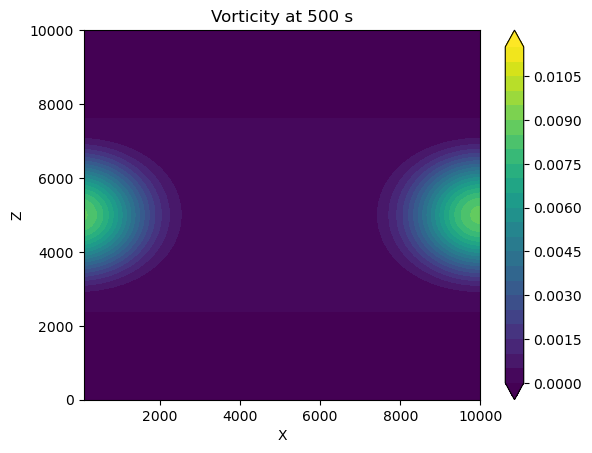

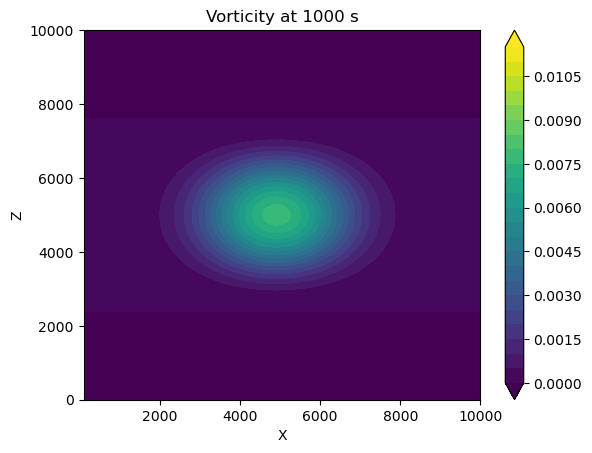

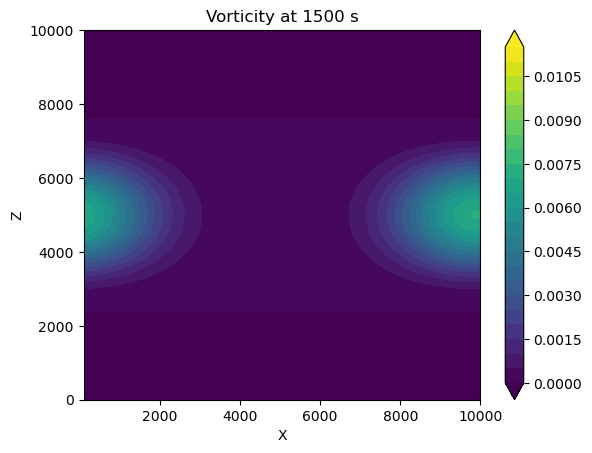

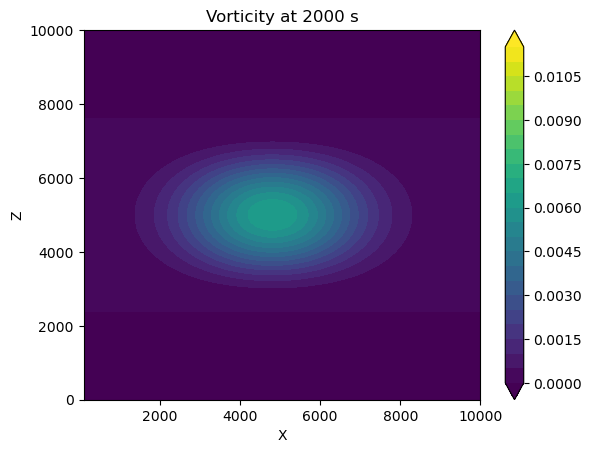

courant number is 0.5


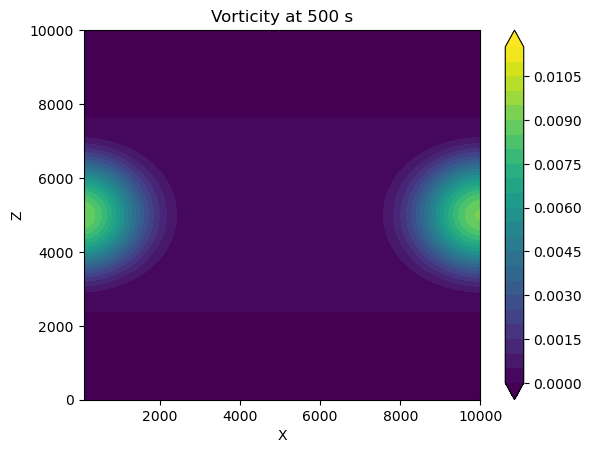

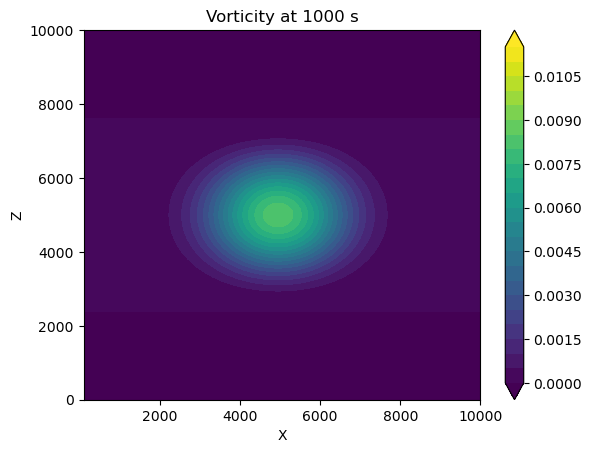

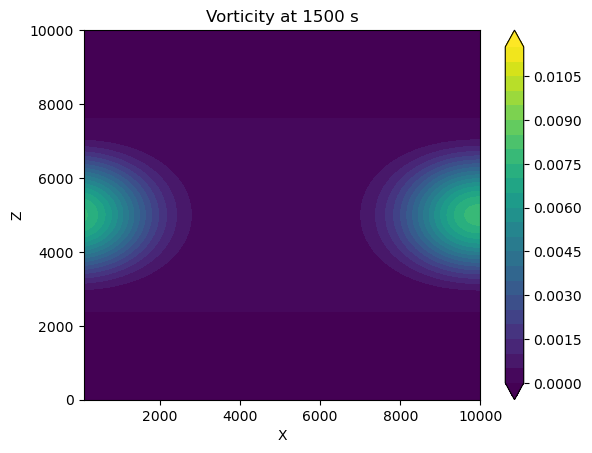

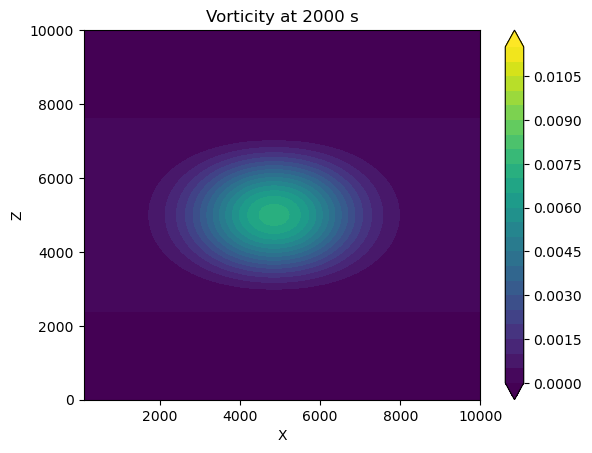

courant number is 0.75


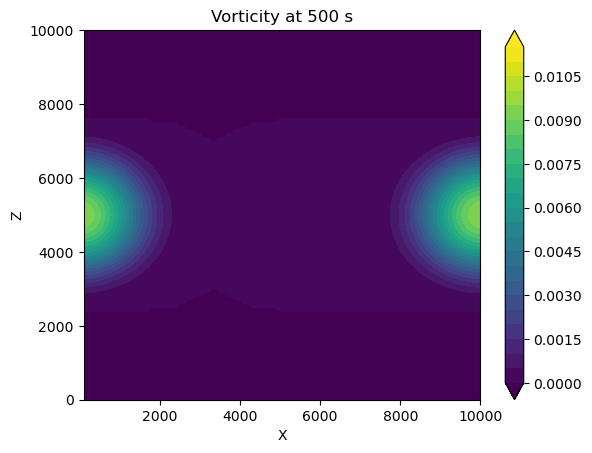

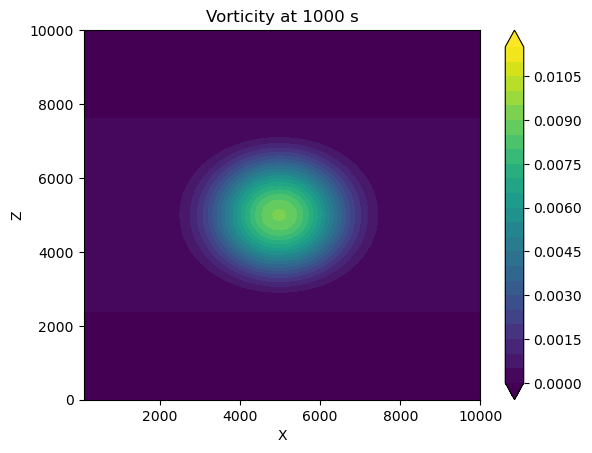

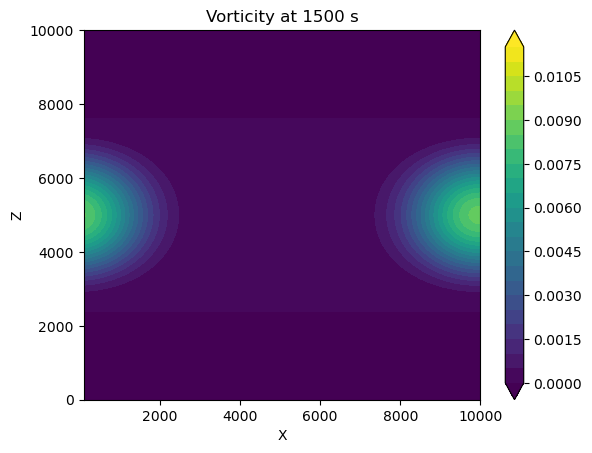

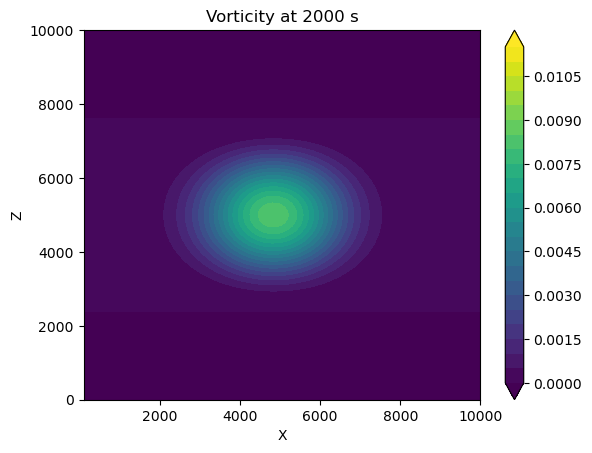

courant number is 1.0


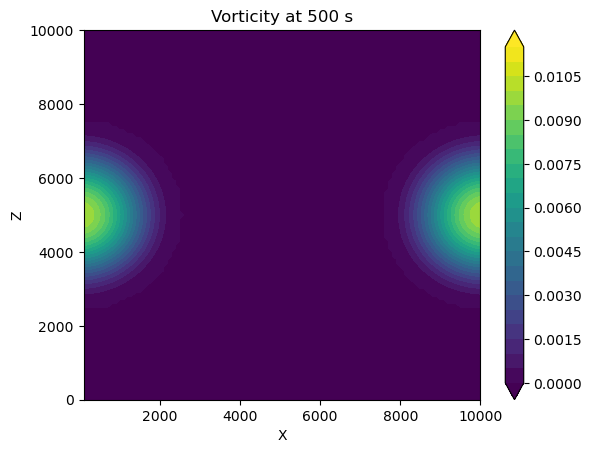

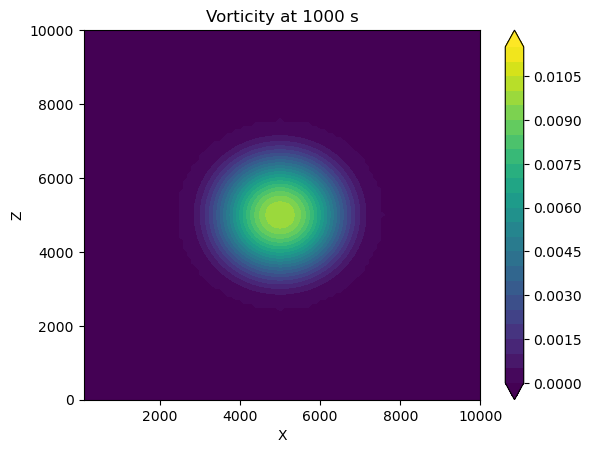

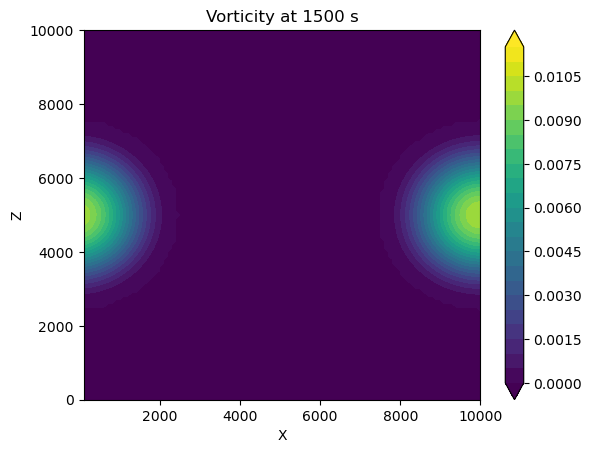

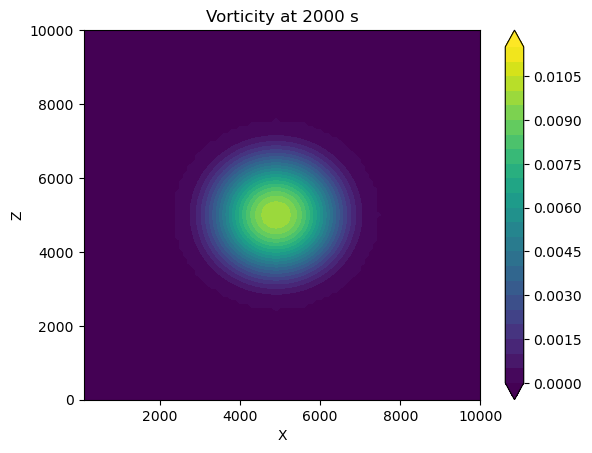

In [219]:
from matplotlib.animation import FuncAnimation

# Define initial value
u = 10  # m/s, constant flow speed
total_time = 2000  # s, total integration time
times_to_plot = [500, 1000, 1500, 2000]  # s, times at which to plot eta
courant_numbers = [0.25, 0.5, 0.75, 1.0]

# Function to implement the forward-in-time, upstream-in-space scheme
def upstream_integration(eta_i, u, dt, dx, dz, courant_number):
    eta_new = np.copy(eta_i)
    for i in range(1, nz - 1):  # Boundary conditions are not updated
        for j in range(1, nx - 1):
            # Upstream scheme for u > 0
            eta_new[i, j] = eta_i[i, j] - courant_number * (eta_i[i, j] - eta_i[i, j - 1])
    apply_boundary_conditions(eta_new)
    return eta_new

# Run the integration for each Courant number
for idx, C in enumerate(courant_numbers):
    print("courant number is", C)
    dt = C * dx / u  # Time step based on the Courant number
    numt = int(total_time/dt)+1 # Number of times
    eta_temp = eta.copy()  # Copy the initial vorticity distribution
    eta_prev = eta_temp.copy()  # To store the previous state
    t_prev = 0  # To store the previous time
    
    for t in range(numt):
        eta_temp = upstream_integration(eta_temp, u, dt, dx, dz, C)
        current_time = t*dt
        # Check if we have passed one of the times to plot
        for plot_time in times_to_plot:
            if t_prev < plot_time <= current_time:
                # Interpolate eta at the plot_time
                eta_at_target = interpolate(eta_prev, eta_temp, t_prev, current_time, plot_time)
                
                # Plotting code
                fig = plt.figure()
                v = plt.contourf(X[:, 1:-2], Z[:, 1:-2], eta_at_target[:, 1:-2], extend='both', levels=np.arange(0.0, 0.0120, 0.0005))
                plt.xlabel('X')
                plt.ylabel('Z')
                plt.title(f'Vorticity at {plot_time} s')
                fig.colorbar(v)
                # filename = f'animation_{idx}_frame_{plot_time}.png'
                # plt.savefig(filename)  # Uncomment to save the figure
                plt.show()
                plt.close()

        # Update previous state and time
        eta_prev = eta_temp.copy()
        t_prev = current_time

    # After the loop, check if we need to plot at the final time
    if times_to_plot[-1] > t_prev:
        eta_at_target = interpolate(eta_prev, eta_temp, t_prev, current_time, times_to_plot[-1])
        # Plotting code for the final time
        fig = plt.figure()
        v = plt.contourf(X[:, 1:-2], Z[:, 1:-2], eta_at_target[:, 1:-2], extend='both', levels=np.arange(0.0, 0.0120, 0.0005))
        plt.xlabel('X')
        plt.ylabel('Z')
        plt.title(f'Vorticity at {times_to_plot[-1]} s')
        fig.colorbar(v)
        # filename = f'animation_{idx}_frame_{times_to_plot[-1]}.png'
        # plt.savefig(filename)  # Uncomment to save the figure
        plt.show()
        plt.close()  


/glade/scratch/mingzhu/ipykernel_30300/3742186595.py:46: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


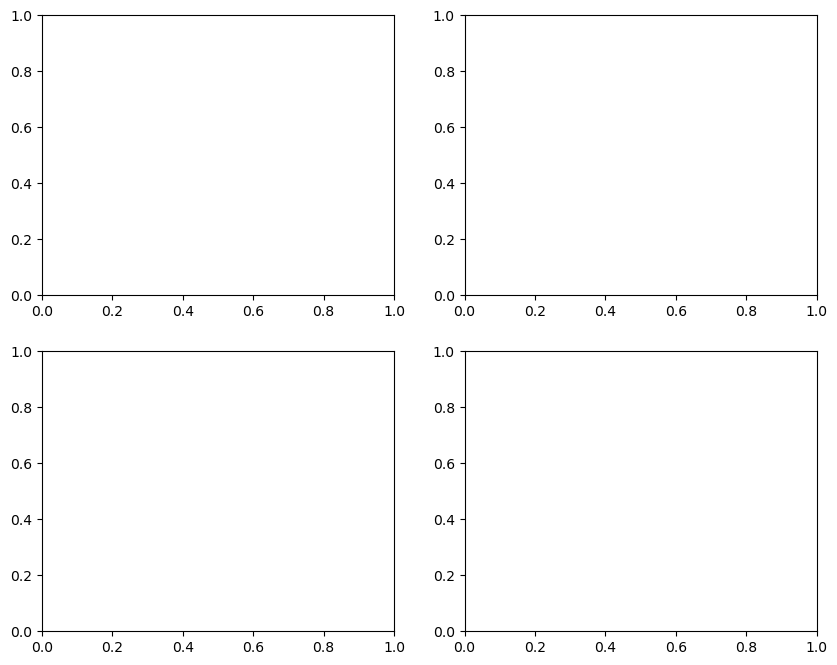

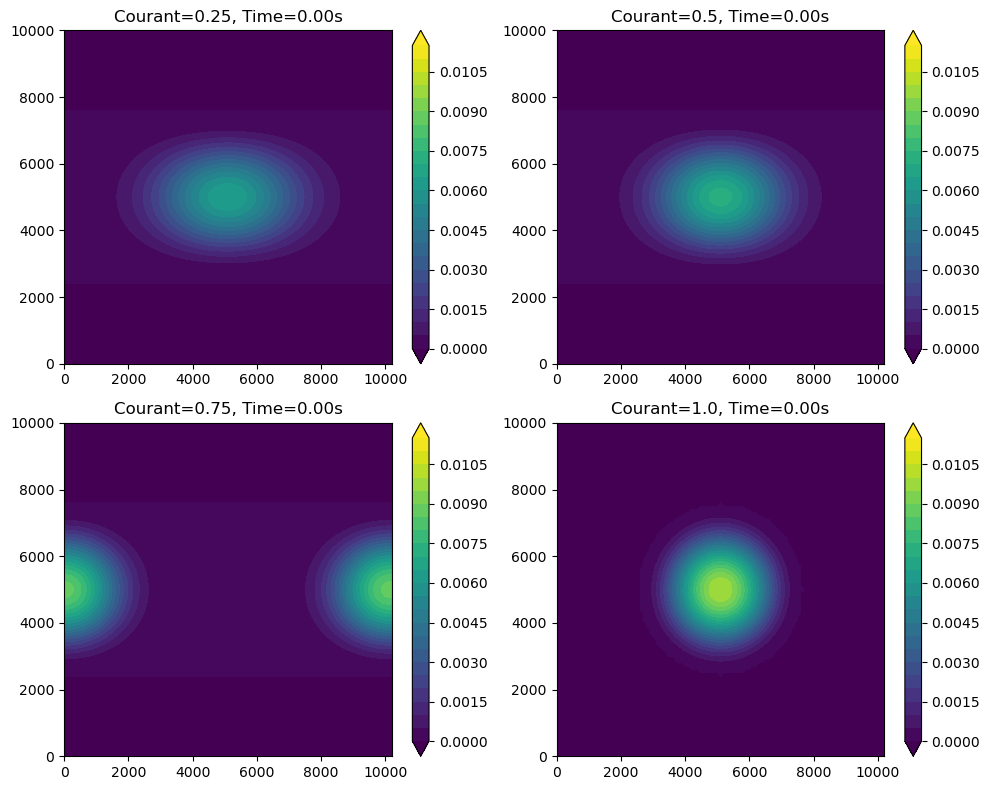

In [230]:
from matplotlib.animation import FuncAnimation
# Define initial value
u = 10  # m/s, constant flow speed
total_time = 2000  # s, total integration time
times_to_plot = [500, 1000, 1500, 2000]  # s, times at which to plot eta
courant_numbers = [0.25, 0.5, 0.75, 1.0]
eta_initial_condition = np.copy(eta)

# Determine the maximum number of frames needed based on the smallest dt
max_frames = max(int(total_time / (C * dx / u)) for C in courant_numbers) + 1
plot_times = np.linspace(0, total_time, num=max_frames)
# Find the largest dt to determine the plotting interval for each subplot
largest_dt = max(C * dx / u for C in courant_numbers)

# Initialize the data structures to hold the state for each Courant number
states = {C: eta_initial_condition.copy() for C in courant_numbers}

# Initialize the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Adjust the size as needed

# Set up the initial state and create a colorbar
for idx, C in enumerate(courant_numbers):
    ax = axs.flatten()[idx]
    dt = C * dx / u
    contour = ax.contourf(X, Z, states[C], extend='both', levels=np.arange(0.0, 0.0120, 0.0005))
    ax.set_title(f'Courant={C}, Time=0.0s')
    
    fig.colorbar(contour, ax=ax)

# Update function for the animation
def update(frame):
    for idx, (C, ax) in enumerate(zip(courant_numbers, axs.flatten())):
        dt = C * dx / u
        steps_to_advance = int(largest_dt / dt)
        for _ in range(steps_to_advance):
            if frame * largest_dt <= total_time:
                states[C] = upstream_integration(states[C], u, dt, dx, dz, C)
        ax.clear()
        contour = ax.contourf(X, Z, states[C], extend='both', levels=np.arange(0.0, 0.0120, 0.0005))
        ax.set_title(f'Courant={C}, Time={frame * largest_dt:.2f}s')
    fig.tight_layout()

# Create the animation
ani = FuncAnimation(fig, update, frames=int(total_time / largest_dt) + 1, interval=100, repeat=False)

# Save the animation with a fixed fps
ani.save('combined_animation1.gif', writer='imagemagick', fps=15)